# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

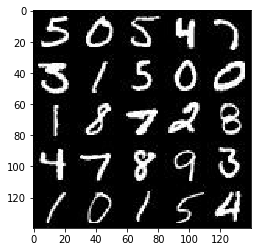

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

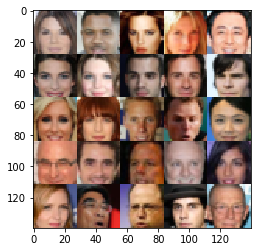

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


In [5]:
# Some fallbacks for old versions of tensorflow (1.3 on AWS)
try:
    leaky_relu = tf.nn.leaky_relu
except AttributeError:
    warnings.warn('Using fallback leaky_relu')
    def leaky_relu(inputs, alpha=0.2):
        return tf.maximum(inputs, inputs * alpha)
    

try:
    flatten = tf.layers.flatten
except AttributeError:
    warnings.warn('Using fallback flatten')
    import functools
    import operator
    
    def flatten(inputs):
        shape = inputs.get_shape()
        target_dim = functools.reduce(operator.mul, map(int, shape[1:]))
        return tf.reshape(inputs, [-1, target_dim])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: UserWarning: Using fallback leaky_relu
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: UserWarning: Using fallback flatten
  del sys.path[0]


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='real_inputs')
    random_inputs = tf.placeholder(tf.float32, shape=[None, z_dim], name='random_inputs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    is_training = tf.placeholder(tf.bool, name='is_training')
    return real_inputs, random_inputs, learning_rate, is_training


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ValueError: too many values to unpack (expected 3)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [14]:
KERNEL_SIZE = 5
STRIDES = 2


def conv2d(inputs, filters, is_training, normalization=True, activation=True, kernel_size=KERNEL_SIZE):
    output = tf.layers.conv2d(
        inputs=inputs, filters=filters,
        kernel_size=kernel_size, strides=STRIDES, padding='same',
        use_bias=not normalization
    )
    if normalization:
        output = tf.layers.batch_normalization(output, training=is_training)
    if activation:
        output = leaky_relu(output)
    return output
    
    
def dense(inputs, units, is_training, normalization=True, activation=True):
    output = tf.layers.dense(
        inputs=inputs, units=units, use_bias=not normalization
    )
    if normalization:
        output = tf.layers.batch_normalization(output, training=is_training)
    if activation:
        output = leaky_relu(output)
    return output
    
    
def discriminator(images, reuse, is_training):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        output = images
        # Shape 28x28xchannels
        output = conv2d(output, 128, is_training, normalization=False)
        # Shape is 14x14
        output = conv2d(output, 256, is_training)
        # Shape 7x7
        output = conv2d(output, 512, is_training)
        # Shape 4x4
        print('discriminator', output.get_shape())
        output = flatten(output)
        # Shape 4*4*512 = 8K
        
        output = dense(output, 512, is_training)
        
        logits = dense(output, 1, is_training, normalization=False, activation=False)
        output = tf.nn.sigmoid(logits)

        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

TypeError: discriminator() missing 2 required positional arguments: 'reuse' and 'is_training'

### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [15]:
def conv2d_transpose(inputs, filters, is_training, normalization=True, activation=True, kernel_size=KERNEL_SIZE):
    output = tf.layers.conv2d_transpose(
        inputs, filters=filters,
        kernel_size=kernel_size, strides=STRIDES, padding='same',
        use_bias=not normalization
    )
    if normalization:
        output = tf.layers.batch_normalization(output, training=is_training)
    if activation:
        output = leaky_relu(output)
    return output


def generator(z, out_channel_dim, is_training, reuse=False):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=reuse):
        output = dense(z, 4 * 4 * 512, is_training, normalization=False, activation=False)
        output = tf.reshape(output, [-1, 4, 4, 512])
        output = tf.layers.batch_normalization(output, training=is_training)
        output = leaky_relu(output)
        
        # Shape is 4x4
        output = conv2d_transpose(output, 256, is_training)
        # Shape is 8x8
        output = conv2d_transpose(output, 128, is_training)
        # Shape ix 16x16
        output = conv2d_transpose(
            output, out_channel_dim, is_training,
            normalization=False, activation=False
        )
        # Shape is 32x32xout_channel_dim
        output = tf.tanh(output)
        output = tf.image.crop_to_bounding_box(output, 2, 2, 28, 28)
        # Shape is 28x28xout_channel_dim
        print('generator out', output.get_shape())
        
        # tanh generates number in range (-1, 1), but we need to output in range (-.5, .5)
        output *= 0.5
        print('after scaling', output.get_shape())
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

TypeError: generator() missing 1 required positional argument: 'is_training'

### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, is_training):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    generator_model = generator(input_z, out_channel_dim, is_training=is_training, reuse=False)
    discriminator_model_real, discriminator_logits_real = discriminator(
        input_real, reuse=False, is_training=is_training
    )
    discriminator_model_fake, discriminator_logits_fake = discriminator(
        generator_model, reuse=True, is_training=is_training
    )
    discriminator_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=discriminator_logits_real, labels=tf.ones_like(discriminator_logits_real)
    ))
    discriminator_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=discriminator_logits_fake, labels=tf.zeros_like(discriminator_logits_fake)
    ))
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=discriminator_logits_fake, labels=tf.ones_like(discriminator_logits_fake)
    ))
    discriminator_loss = discriminator_real_loss + discriminator_fake_loss
    
    return discriminator_loss, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

TypeError: model_loss() missing 1 required positional argument: 'is_training'

### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    trainable_vars = tf.trainable_variables()
    discriminator_variables = [var for var in trainable_vars if var.name.startswith('discriminator')]
    generator_variables = [var for var in trainable_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        discriminator_optimizer = tf.train.AdamOptimizer(
            learning_rate=learning_rate, beta1=beta1
        ).minimize(
            d_loss, var_list=discriminator_variables
        )
        generator_optimizer = tf.train.AdamOptimizer(
            learning_rate=learning_rate, beta1=beta1
        ).minimize(
            g_loss, var_list=generator_variables
        )
    
    return discriminator_optimizer, generator_optimizer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode, is_training):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, is_training, reuse=True),
        feed_dict={input_z: example_z, is_training: False}
    )
    print('gen images', n_images, example_z.shape, '->', samples.shape)

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [17]:
PRINT_EVERY = 5
VIEW_EVERY = PRINT_EVERY * 3

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    number_of_examples, *_, out_channel_dim = data_shape
    real_images, z, learning_rate_tensor, is_training = model_inputs(*data_shape[1:], z_dim)
    batches_per_epoch = int(number_of_examples / batch_size)
    
    discriminator_loss, generator_loss = model_loss(real_images, z, out_channel_dim, is_training=is_training)
    discriminator_opt, generator_opt = model_opt(discriminator_loss, generator_loss, learning_rate_tensor, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        step = 0
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                feed_dict = {
                    real_images: batch_images,
                    z: batch_z,
                    learning_rate_tensor: learning_rate,
                    is_training: True
                }
                sess.run(discriminator_opt, feed_dict=feed_dict)
                sess.run(generator_opt, feed_dict=feed_dict)
                if step % PRINT_EVERY == 0:
                    train_loss_discriminator = discriminator_loss.eval(feed_dict)
                    train_loss_generator = generator_loss.eval(feed_dict)
                    print(
                        'Epoch {epoch_i}/{epoch_count} '
                        'Step {step}/{steps}: '
                        'Discriminator Loss: {train_loss_discriminator:.4f}. '
                        'Generator Loss: {train_loss_generator:.4f}'.format(
                            epoch_i=epoch_i + 1,
                            epoch_count=epoch_count,
                            step=step + 1,
                            steps=batches_per_epoch * epoch_count,
                            train_loss_generator=train_loss_generator,
                            train_loss_discriminator=train_loss_discriminator
                        )
                    )
                if step % VIEW_EVERY == 0:
                    show_generator_output(sess, 16, z, out_channel_dim, data_image_mode, is_training)
                step += 1
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
discriminator (?, 4, 4, 512)
discriminator (?, 4, 4, 512)
Epoch 1/2 Step 0/936: Discriminator Loss: 7.7867. Generator Loss: 4.5718
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


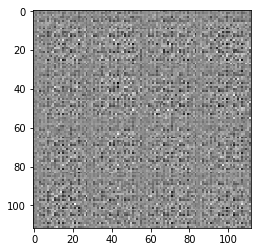

Epoch 1/2 Step 5/936: Discriminator Loss: 1.7329. Generator Loss: 1.1729
Epoch 1/2 Step 10/936: Discriminator Loss: 1.5024. Generator Loss: 0.9945
Epoch 1/2 Step 15/936: Discriminator Loss: 1.4142. Generator Loss: 0.9081
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


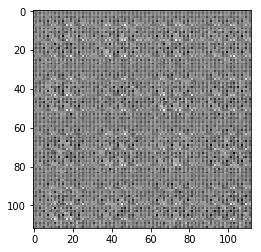

Epoch 1/2 Step 20/936: Discriminator Loss: 1.1198. Generator Loss: 0.8275
Epoch 1/2 Step 25/936: Discriminator Loss: 1.0577. Generator Loss: 0.8570
Epoch 1/2 Step 30/936: Discriminator Loss: 1.1297. Generator Loss: 0.8878
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


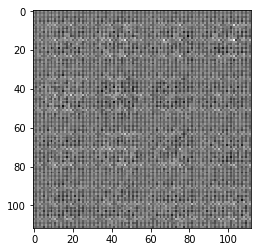

Epoch 1/2 Step 35/936: Discriminator Loss: 1.1231. Generator Loss: 0.9779
Epoch 1/2 Step 40/936: Discriminator Loss: 0.9946. Generator Loss: 0.9484
Epoch 1/2 Step 45/936: Discriminator Loss: 0.9124. Generator Loss: 0.9303
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


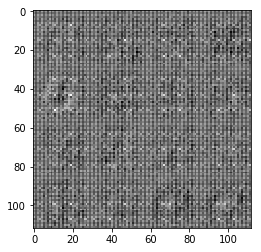

Epoch 1/2 Step 50/936: Discriminator Loss: 0.9161. Generator Loss: 0.9079
Epoch 1/2 Step 55/936: Discriminator Loss: 0.9518. Generator Loss: 1.0566
Epoch 1/2 Step 60/936: Discriminator Loss: 1.1343. Generator Loss: 0.9180
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


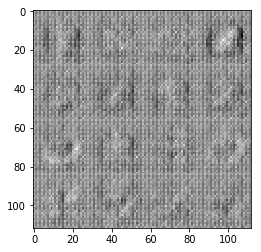

Epoch 1/2 Step 65/936: Discriminator Loss: 1.0355. Generator Loss: 0.9490
Epoch 1/2 Step 70/936: Discriminator Loss: 1.2177. Generator Loss: 0.9162
Epoch 1/2 Step 75/936: Discriminator Loss: 1.0168. Generator Loss: 0.9639
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


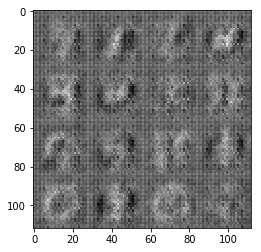

Epoch 1/2 Step 80/936: Discriminator Loss: 1.0436. Generator Loss: 0.9068
Epoch 1/2 Step 85/936: Discriminator Loss: 1.0648. Generator Loss: 0.8676
Epoch 1/2 Step 90/936: Discriminator Loss: 1.1414. Generator Loss: 0.8348
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


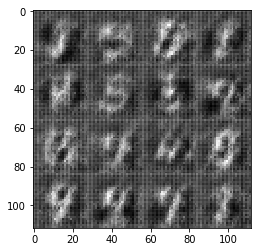

Epoch 1/2 Step 95/936: Discriminator Loss: 1.0169. Generator Loss: 0.8331
Epoch 1/2 Step 100/936: Discriminator Loss: 1.2207. Generator Loss: 0.9082
Epoch 1/2 Step 105/936: Discriminator Loss: 1.1102. Generator Loss: 0.9303
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


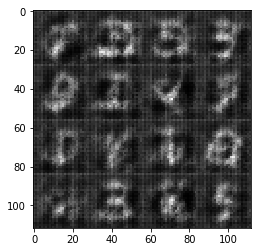

Epoch 1/2 Step 110/936: Discriminator Loss: 1.0629. Generator Loss: 0.7733
Epoch 1/2 Step 115/936: Discriminator Loss: 1.1136. Generator Loss: 0.7814
Epoch 1/2 Step 120/936: Discriminator Loss: 1.1019. Generator Loss: 0.8400
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


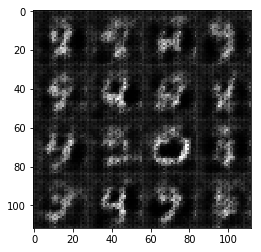

Epoch 1/2 Step 125/936: Discriminator Loss: 1.0360. Generator Loss: 0.8355
Epoch 1/2 Step 130/936: Discriminator Loss: 1.0762. Generator Loss: 0.8754
Epoch 1/2 Step 135/936: Discriminator Loss: 1.1223. Generator Loss: 0.8378
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


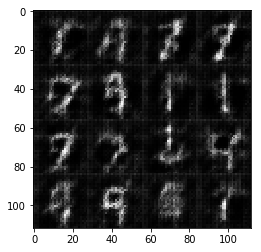

Epoch 1/2 Step 140/936: Discriminator Loss: 1.1578. Generator Loss: 0.8862
Epoch 1/2 Step 145/936: Discriminator Loss: 1.1182. Generator Loss: 0.8427
Epoch 1/2 Step 150/936: Discriminator Loss: 1.0525. Generator Loss: 0.7614
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


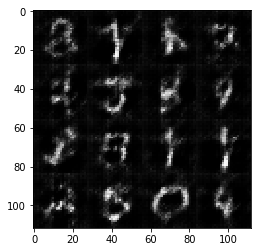

Epoch 1/2 Step 155/936: Discriminator Loss: 1.1349. Generator Loss: 0.7673
Epoch 1/2 Step 160/936: Discriminator Loss: 1.0304. Generator Loss: 0.8846
Epoch 1/2 Step 165/936: Discriminator Loss: 1.1050. Generator Loss: 0.8557
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


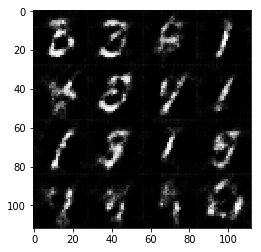

Epoch 1/2 Step 170/936: Discriminator Loss: 1.1726. Generator Loss: 0.7628
Epoch 1/2 Step 175/936: Discriminator Loss: 1.1039. Generator Loss: 0.8703
Epoch 1/2 Step 180/936: Discriminator Loss: 1.1106. Generator Loss: 0.8167
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


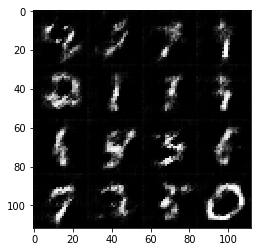

Epoch 1/2 Step 185/936: Discriminator Loss: 1.1306. Generator Loss: 0.7985
Epoch 1/2 Step 190/936: Discriminator Loss: 1.1630. Generator Loss: 0.8384
Epoch 1/2 Step 195/936: Discriminator Loss: 1.0139. Generator Loss: 0.9230
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


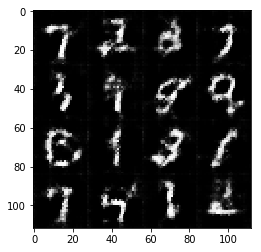

Epoch 1/2 Step 200/936: Discriminator Loss: 1.1994. Generator Loss: 0.9370
Epoch 1/2 Step 205/936: Discriminator Loss: 1.0292. Generator Loss: 0.7988
Epoch 1/2 Step 210/936: Discriminator Loss: 1.1244. Generator Loss: 0.9337
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


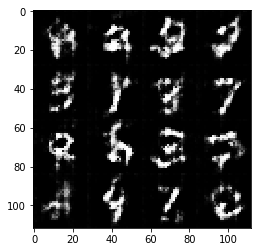

Epoch 1/2 Step 215/936: Discriminator Loss: 1.1126. Generator Loss: 0.8700
Epoch 1/2 Step 220/936: Discriminator Loss: 1.0599. Generator Loss: 0.9192
Epoch 1/2 Step 225/936: Discriminator Loss: 1.1879. Generator Loss: 0.8274
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


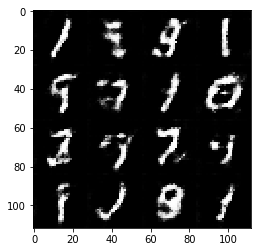

Epoch 1/2 Step 230/936: Discriminator Loss: 1.2462. Generator Loss: 1.0055
Epoch 1/2 Step 235/936: Discriminator Loss: 1.0955. Generator Loss: 0.7869
Epoch 1/2 Step 240/936: Discriminator Loss: 1.0774. Generator Loss: 0.8559
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


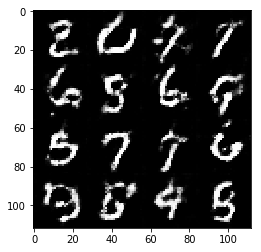

Epoch 1/2 Step 245/936: Discriminator Loss: 0.9654. Generator Loss: 0.8817
Epoch 1/2 Step 250/936: Discriminator Loss: 1.0541. Generator Loss: 0.8560
Epoch 1/2 Step 255/936: Discriminator Loss: 1.0945. Generator Loss: 0.8650
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


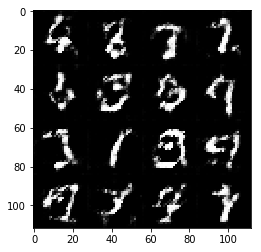

Epoch 1/2 Step 260/936: Discriminator Loss: 1.1400. Generator Loss: 1.0341
Epoch 1/2 Step 265/936: Discriminator Loss: 1.1507. Generator Loss: 0.8385
Epoch 1/2 Step 270/936: Discriminator Loss: 1.2694. Generator Loss: 0.8461
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


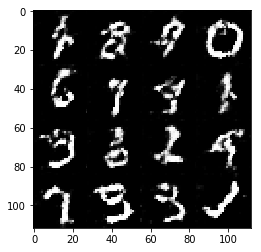

Epoch 1/2 Step 275/936: Discriminator Loss: 1.2256. Generator Loss: 0.9803
Epoch 1/2 Step 280/936: Discriminator Loss: 0.9718. Generator Loss: 0.8201
Epoch 1/2 Step 285/936: Discriminator Loss: 1.1219. Generator Loss: 0.8182
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


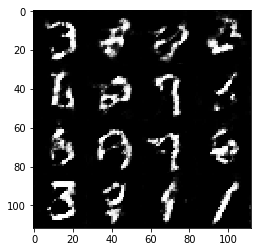

Epoch 1/2 Step 290/936: Discriminator Loss: 0.9928. Generator Loss: 0.8885
Epoch 1/2 Step 295/936: Discriminator Loss: 1.0885. Generator Loss: 0.8858
Epoch 1/2 Step 300/936: Discriminator Loss: 1.2037. Generator Loss: 0.8615
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


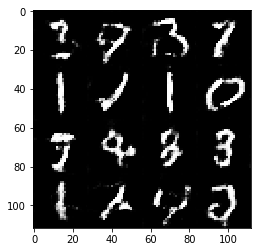

Epoch 1/2 Step 305/936: Discriminator Loss: 1.0494. Generator Loss: 0.8555
Epoch 1/2 Step 310/936: Discriminator Loss: 1.0112. Generator Loss: 0.8354
Epoch 1/2 Step 315/936: Discriminator Loss: 0.9781. Generator Loss: 0.9272
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


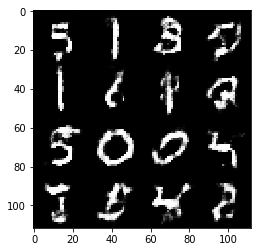

Epoch 1/2 Step 320/936: Discriminator Loss: 0.9965. Generator Loss: 0.9150
Epoch 1/2 Step 325/936: Discriminator Loss: 1.0117. Generator Loss: 0.9669
Epoch 1/2 Step 330/936: Discriminator Loss: 1.1249. Generator Loss: 0.8531
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


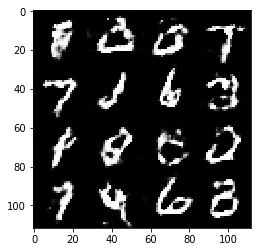

Epoch 1/2 Step 335/936: Discriminator Loss: 1.0357. Generator Loss: 0.8101
Epoch 1/2 Step 340/936: Discriminator Loss: 0.9728. Generator Loss: 0.8749
Epoch 1/2 Step 345/936: Discriminator Loss: 1.0159. Generator Loss: 0.9671
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


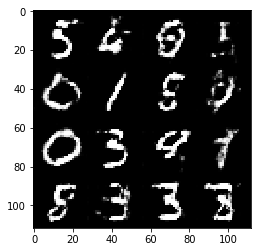

Epoch 1/2 Step 350/936: Discriminator Loss: 1.2011. Generator Loss: 0.9094
Epoch 1/2 Step 355/936: Discriminator Loss: 1.1574. Generator Loss: 0.7673
Epoch 1/2 Step 360/936: Discriminator Loss: 1.0605. Generator Loss: 0.8712
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


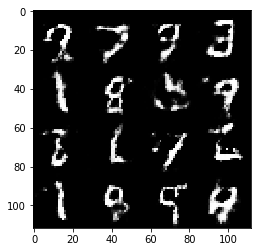

Epoch 1/2 Step 365/936: Discriminator Loss: 1.1000. Generator Loss: 0.8674
Epoch 1/2 Step 370/936: Discriminator Loss: 0.9681. Generator Loss: 0.8758
Epoch 1/2 Step 375/936: Discriminator Loss: 1.0291. Generator Loss: 0.8346
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


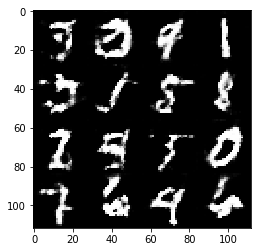

Epoch 1/2 Step 380/936: Discriminator Loss: 1.0990. Generator Loss: 0.8930
Epoch 1/2 Step 385/936: Discriminator Loss: 0.9497. Generator Loss: 0.8983
Epoch 1/2 Step 390/936: Discriminator Loss: 0.9949. Generator Loss: 0.8777
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


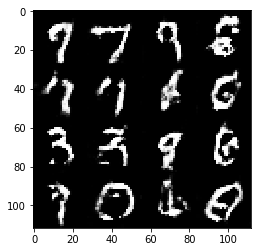

Epoch 1/2 Step 395/936: Discriminator Loss: 0.9278. Generator Loss: 0.9394
Epoch 1/2 Step 400/936: Discriminator Loss: 1.1231. Generator Loss: 0.9611
Epoch 1/2 Step 405/936: Discriminator Loss: 1.0615. Generator Loss: 1.0669
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


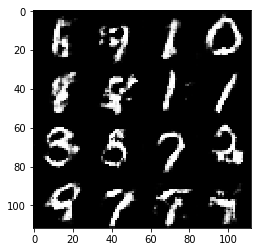

Epoch 1/2 Step 410/936: Discriminator Loss: 0.9880. Generator Loss: 0.8593
Epoch 1/2 Step 415/936: Discriminator Loss: 0.9356. Generator Loss: 0.8623
Epoch 1/2 Step 420/936: Discriminator Loss: 0.9440. Generator Loss: 1.0377
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


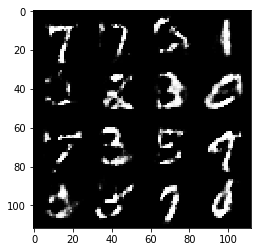

Epoch 1/2 Step 425/936: Discriminator Loss: 0.9902. Generator Loss: 0.9601
Epoch 1/2 Step 430/936: Discriminator Loss: 1.0951. Generator Loss: 0.9595
Epoch 1/2 Step 435/936: Discriminator Loss: 0.9502. Generator Loss: 0.9025
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


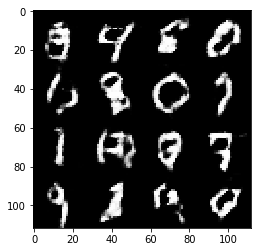

Epoch 1/2 Step 440/936: Discriminator Loss: 1.0752. Generator Loss: 0.8023
Epoch 1/2 Step 445/936: Discriminator Loss: 1.0053. Generator Loss: 0.8599
Epoch 1/2 Step 450/936: Discriminator Loss: 0.9162. Generator Loss: 0.9765
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


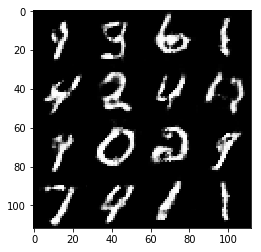

Epoch 1/2 Step 455/936: Discriminator Loss: 0.9892. Generator Loss: 0.8919
Epoch 1/2 Step 460/936: Discriminator Loss: 1.0727. Generator Loss: 0.8328
Epoch 1/2 Step 465/936: Discriminator Loss: 1.2605. Generator Loss: 0.7879
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


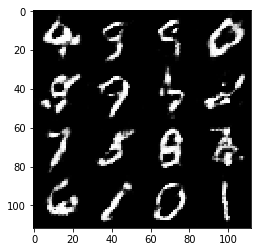

Epoch 2/2 Step 470/936: Discriminator Loss: 1.0665. Generator Loss: 0.8002
Epoch 2/2 Step 475/936: Discriminator Loss: 1.0138. Generator Loss: 0.8513
Epoch 2/2 Step 480/936: Discriminator Loss: 0.9505. Generator Loss: 0.8570
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


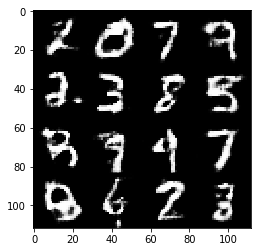

Epoch 2/2 Step 485/936: Discriminator Loss: 1.0550. Generator Loss: 0.7398
Epoch 2/2 Step 490/936: Discriminator Loss: 0.9260. Generator Loss: 0.8951
Epoch 2/2 Step 495/936: Discriminator Loss: 0.8633. Generator Loss: 0.9757
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


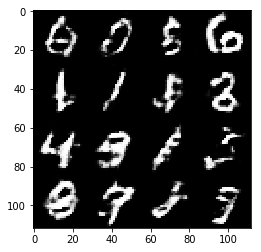

Epoch 2/2 Step 500/936: Discriminator Loss: 1.0738. Generator Loss: 0.7762
Epoch 2/2 Step 505/936: Discriminator Loss: 0.9982. Generator Loss: 0.9277
Epoch 2/2 Step 510/936: Discriminator Loss: 1.0597. Generator Loss: 0.9981
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


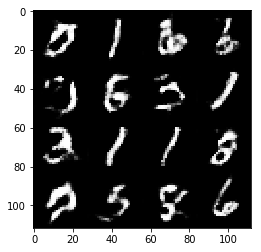

Epoch 2/2 Step 515/936: Discriminator Loss: 1.0526. Generator Loss: 0.9850
Epoch 2/2 Step 520/936: Discriminator Loss: 1.0022. Generator Loss: 0.9259
Epoch 2/2 Step 525/936: Discriminator Loss: 1.0728. Generator Loss: 0.8728
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


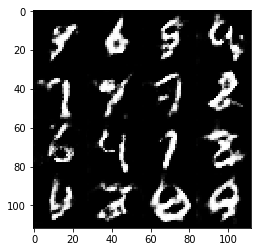

Epoch 2/2 Step 530/936: Discriminator Loss: 1.0219. Generator Loss: 0.9712
Epoch 2/2 Step 535/936: Discriminator Loss: 1.0073. Generator Loss: 0.9102
Epoch 2/2 Step 540/936: Discriminator Loss: 0.8924. Generator Loss: 1.0335
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


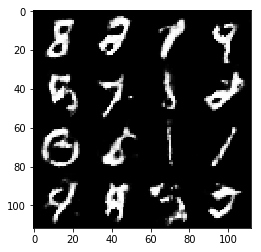

Epoch 2/2 Step 545/936: Discriminator Loss: 1.2930. Generator Loss: 1.1295
Epoch 2/2 Step 550/936: Discriminator Loss: 1.0356. Generator Loss: 0.9195
Epoch 2/2 Step 555/936: Discriminator Loss: 1.0969. Generator Loss: 1.0572
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


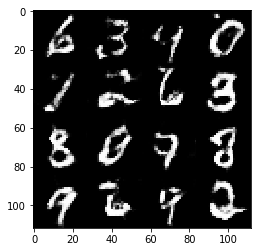

Epoch 2/2 Step 560/936: Discriminator Loss: 0.9729. Generator Loss: 0.8825
Epoch 2/2 Step 565/936: Discriminator Loss: 0.9120. Generator Loss: 0.8609
Epoch 2/2 Step 570/936: Discriminator Loss: 0.9994. Generator Loss: 0.9980
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


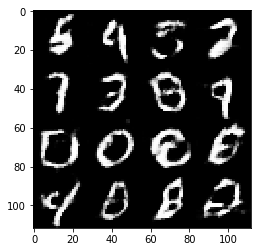

Epoch 2/2 Step 575/936: Discriminator Loss: 0.9165. Generator Loss: 1.0442
Epoch 2/2 Step 580/936: Discriminator Loss: 0.9568. Generator Loss: 0.8182
Epoch 2/2 Step 585/936: Discriminator Loss: 0.8723. Generator Loss: 0.8944
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


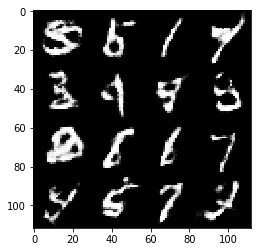

Epoch 2/2 Step 590/936: Discriminator Loss: 0.8315. Generator Loss: 0.9656
Epoch 2/2 Step 595/936: Discriminator Loss: 0.9191. Generator Loss: 0.9809
Epoch 2/2 Step 600/936: Discriminator Loss: 0.9084. Generator Loss: 0.9528
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


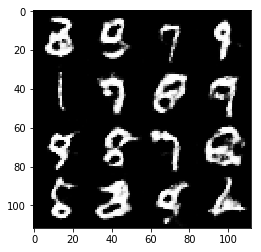

Epoch 2/2 Step 605/936: Discriminator Loss: 0.7913. Generator Loss: 1.0964
Epoch 2/2 Step 610/936: Discriminator Loss: 1.0622. Generator Loss: 0.9256
Epoch 2/2 Step 615/936: Discriminator Loss: 1.1690. Generator Loss: 1.2339
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


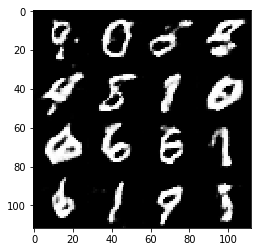

Epoch 2/2 Step 620/936: Discriminator Loss: 1.0973. Generator Loss: 0.8223
Epoch 2/2 Step 625/936: Discriminator Loss: 1.0048. Generator Loss: 0.8242
Epoch 2/2 Step 630/936: Discriminator Loss: 0.8082. Generator Loss: 1.0098
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


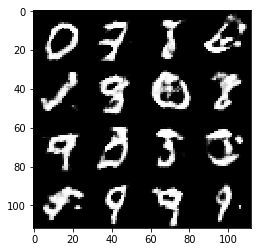

Epoch 2/2 Step 635/936: Discriminator Loss: 0.9130. Generator Loss: 1.0969
Epoch 2/2 Step 640/936: Discriminator Loss: 0.8973. Generator Loss: 0.9043
Epoch 2/2 Step 645/936: Discriminator Loss: 1.1843. Generator Loss: 0.9459
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


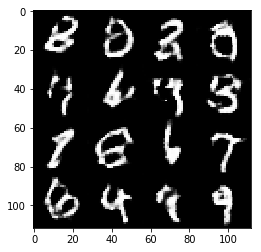

Epoch 2/2 Step 650/936: Discriminator Loss: 1.0328. Generator Loss: 0.8394
Epoch 2/2 Step 655/936: Discriminator Loss: 0.9018. Generator Loss: 0.9887
Epoch 2/2 Step 660/936: Discriminator Loss: 0.8983. Generator Loss: 0.9742
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


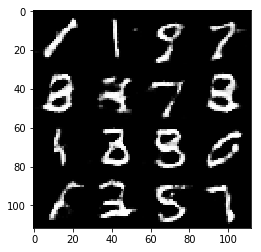

Epoch 2/2 Step 665/936: Discriminator Loss: 0.8788. Generator Loss: 0.8442
Epoch 2/2 Step 670/936: Discriminator Loss: 0.8019. Generator Loss: 0.9737
Epoch 2/2 Step 675/936: Discriminator Loss: 0.7933. Generator Loss: 1.1057
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


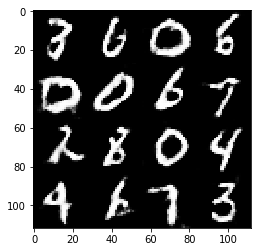

Epoch 2/2 Step 680/936: Discriminator Loss: 0.8428. Generator Loss: 1.3452
Epoch 2/2 Step 685/936: Discriminator Loss: 0.7531. Generator Loss: 1.0103
Epoch 2/2 Step 690/936: Discriminator Loss: 1.0501. Generator Loss: 0.7481
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


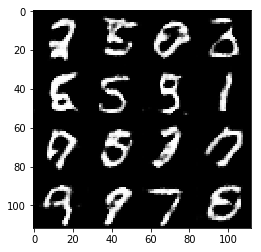

Epoch 2/2 Step 695/936: Discriminator Loss: 0.8868. Generator Loss: 0.9885
Epoch 2/2 Step 700/936: Discriminator Loss: 0.9404. Generator Loss: 0.8354
Epoch 2/2 Step 705/936: Discriminator Loss: 0.8283. Generator Loss: 1.0603
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


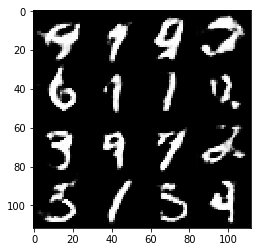

Epoch 2/2 Step 710/936: Discriminator Loss: 0.7079. Generator Loss: 1.3104
Epoch 2/2 Step 715/936: Discriminator Loss: 0.7614. Generator Loss: 1.1723
Epoch 2/2 Step 720/936: Discriminator Loss: 1.3128. Generator Loss: 0.8123
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


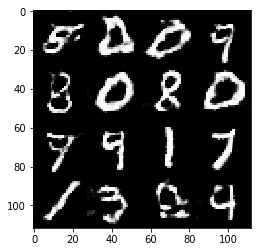

Epoch 2/2 Step 725/936: Discriminator Loss: 0.9517. Generator Loss: 1.0074
Epoch 2/2 Step 730/936: Discriminator Loss: 0.8053. Generator Loss: 1.1687
Epoch 2/2 Step 735/936: Discriminator Loss: 0.7955. Generator Loss: 1.3450
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


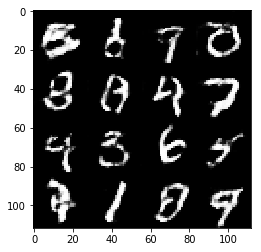

Epoch 2/2 Step 740/936: Discriminator Loss: 0.8039. Generator Loss: 1.0440
Epoch 2/2 Step 745/936: Discriminator Loss: 0.8501. Generator Loss: 0.9629
Epoch 2/2 Step 750/936: Discriminator Loss: 0.7766. Generator Loss: 1.2421
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


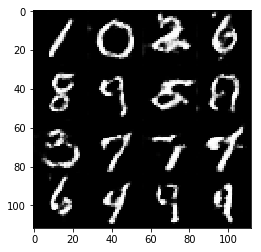

Epoch 2/2 Step 755/936: Discriminator Loss: 0.7579. Generator Loss: 0.9928
Epoch 2/2 Step 760/936: Discriminator Loss: 1.6054. Generator Loss: 1.8949
Epoch 2/2 Step 765/936: Discriminator Loss: 1.0989. Generator Loss: 1.0091
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


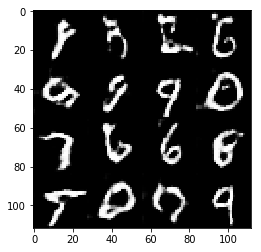

Epoch 2/2 Step 770/936: Discriminator Loss: 1.2154. Generator Loss: 0.8894
Epoch 2/2 Step 775/936: Discriminator Loss: 0.9627. Generator Loss: 0.8154
Epoch 2/2 Step 780/936: Discriminator Loss: 0.8212. Generator Loss: 0.9204
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


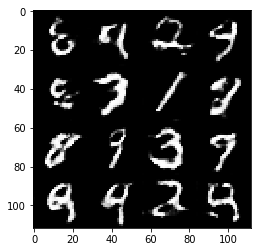

Epoch 2/2 Step 785/936: Discriminator Loss: 1.0099. Generator Loss: 0.9012
Epoch 2/2 Step 790/936: Discriminator Loss: 0.7126. Generator Loss: 1.2078
Epoch 2/2 Step 795/936: Discriminator Loss: 0.7971. Generator Loss: 1.0413
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


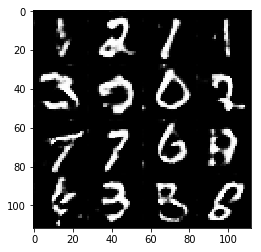

Epoch 2/2 Step 800/936: Discriminator Loss: 0.8431. Generator Loss: 0.9294
Epoch 2/2 Step 805/936: Discriminator Loss: 0.9833. Generator Loss: 0.8454
Epoch 2/2 Step 810/936: Discriminator Loss: 0.8685. Generator Loss: 1.0415
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


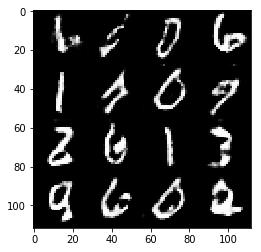

Epoch 2/2 Step 815/936: Discriminator Loss: 0.9454. Generator Loss: 0.8792
Epoch 2/2 Step 820/936: Discriminator Loss: 0.7920. Generator Loss: 1.2385
Epoch 2/2 Step 825/936: Discriminator Loss: 0.6628. Generator Loss: 1.0919
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


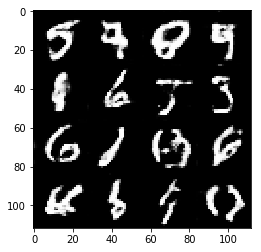

Epoch 2/2 Step 830/936: Discriminator Loss: 0.6994. Generator Loss: 1.0313
Epoch 2/2 Step 835/936: Discriminator Loss: 0.7644. Generator Loss: 1.1956
Epoch 2/2 Step 840/936: Discriminator Loss: 0.7780. Generator Loss: 1.0400
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


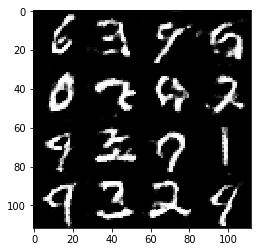

Epoch 2/2 Step 845/936: Discriminator Loss: 0.8959. Generator Loss: 1.0647
Epoch 2/2 Step 850/936: Discriminator Loss: 1.0040. Generator Loss: 0.8625
Epoch 2/2 Step 855/936: Discriminator Loss: 0.8911. Generator Loss: 0.8547
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


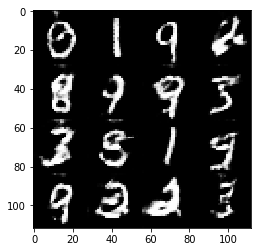

Epoch 2/2 Step 860/936: Discriminator Loss: 0.8336. Generator Loss: 1.0451
Epoch 2/2 Step 865/936: Discriminator Loss: 0.9209. Generator Loss: 1.1463
Epoch 2/2 Step 870/936: Discriminator Loss: 0.7770. Generator Loss: 1.0149
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


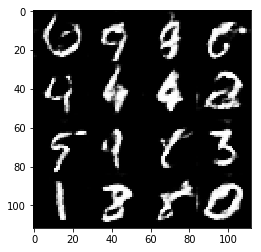

Epoch 2/2 Step 875/936: Discriminator Loss: 0.7689. Generator Loss: 1.1286
Epoch 2/2 Step 880/936: Discriminator Loss: 0.8480. Generator Loss: 0.9319
Epoch 2/2 Step 885/936: Discriminator Loss: 0.8073. Generator Loss: 1.0119
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


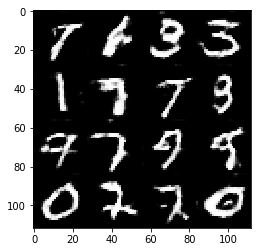

Epoch 2/2 Step 890/936: Discriminator Loss: 0.7401. Generator Loss: 0.9497
Epoch 2/2 Step 895/936: Discriminator Loss: 0.6117. Generator Loss: 1.0770
Epoch 2/2 Step 900/936: Discriminator Loss: 0.9276. Generator Loss: 1.3653
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


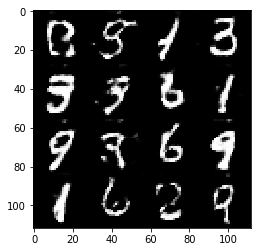

Epoch 2/2 Step 905/936: Discriminator Loss: 1.1415. Generator Loss: 1.1404
Epoch 2/2 Step 910/936: Discriminator Loss: 0.8688. Generator Loss: 1.3125
Epoch 2/2 Step 915/936: Discriminator Loss: 0.8912. Generator Loss: 0.9649
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


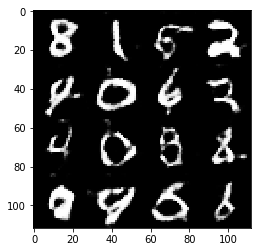

Epoch 2/2 Step 920/936: Discriminator Loss: 0.9162. Generator Loss: 0.9203
Epoch 2/2 Step 925/936: Discriminator Loss: 0.7598. Generator Loss: 1.2047
Epoch 2/2 Step 930/936: Discriminator Loss: 1.1152. Generator Loss: 1.2719
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


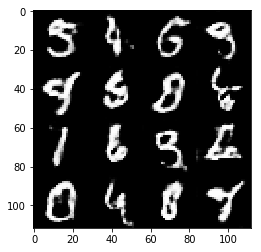

Epoch 2/2 Step 935/936: Discriminator Loss: 0.7592. Generator Loss: 1.1413


In [16]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
discriminator (?, 4, 4, 512)
discriminator (?, 4, 4, 512)
Epoch 1/1 Step 1/791: Discriminator Loss: 4.7701. Generator Loss: 2.0062
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


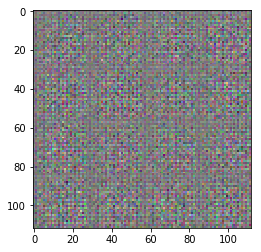

Epoch 1/1 Step 6/791: Discriminator Loss: 1.7767. Generator Loss: 1.2676
Epoch 1/1 Step 11/791: Discriminator Loss: 1.5677. Generator Loss: 1.1960
Epoch 1/1 Step 16/791: Discriminator Loss: 1.6455. Generator Loss: 1.1452
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


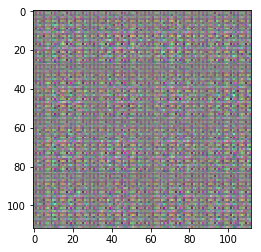

Epoch 1/1 Step 21/791: Discriminator Loss: 1.2633. Generator Loss: 0.9927
Epoch 1/1 Step 26/791: Discriminator Loss: 1.0420. Generator Loss: 0.9301
Epoch 1/1 Step 31/791: Discriminator Loss: 1.4058. Generator Loss: 1.0505
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


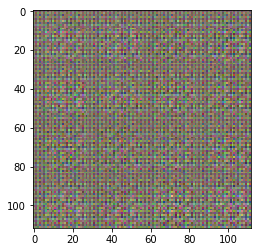

Epoch 1/1 Step 36/791: Discriminator Loss: 0.9173. Generator Loss: 0.9182
Epoch 1/1 Step 41/791: Discriminator Loss: 0.9403. Generator Loss: 0.8906
Epoch 1/1 Step 46/791: Discriminator Loss: 1.0258. Generator Loss: 0.8137
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


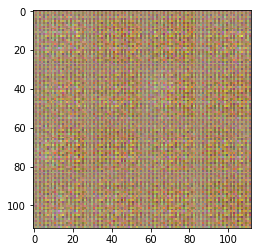

Epoch 1/1 Step 51/791: Discriminator Loss: 1.1142. Generator Loss: 1.1330
Epoch 1/1 Step 56/791: Discriminator Loss: 1.0003. Generator Loss: 1.0384
Epoch 1/1 Step 61/791: Discriminator Loss: 0.9065. Generator Loss: 0.9318
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


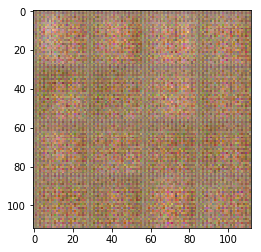

Epoch 1/1 Step 66/791: Discriminator Loss: 0.9668. Generator Loss: 1.0283
Epoch 1/1 Step 71/791: Discriminator Loss: 1.0127. Generator Loss: 1.1980
Epoch 1/1 Step 76/791: Discriminator Loss: 1.1254. Generator Loss: 0.7882
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


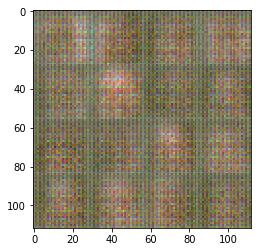

Epoch 1/1 Step 81/791: Discriminator Loss: 1.0345. Generator Loss: 0.9007
Epoch 1/1 Step 86/791: Discriminator Loss: 0.8913. Generator Loss: 1.1086
Epoch 1/1 Step 91/791: Discriminator Loss: 0.9614. Generator Loss: 0.9763
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


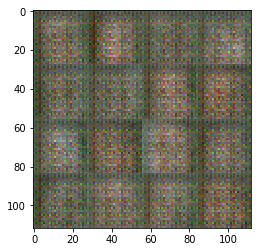

Epoch 1/1 Step 96/791: Discriminator Loss: 0.9763. Generator Loss: 0.8555
Epoch 1/1 Step 101/791: Discriminator Loss: 1.1218. Generator Loss: 0.6667
Epoch 1/1 Step 106/791: Discriminator Loss: 0.9957. Generator Loss: 0.8371
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


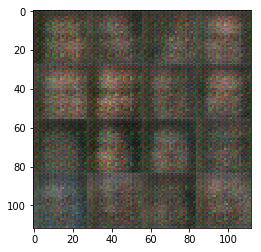

Epoch 1/1 Step 111/791: Discriminator Loss: 0.9783. Generator Loss: 0.7802
Epoch 1/1 Step 116/791: Discriminator Loss: 0.9453. Generator Loss: 1.0651
Epoch 1/1 Step 121/791: Discriminator Loss: 0.9267. Generator Loss: 1.0470
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


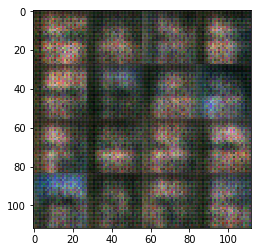

Epoch 1/1 Step 126/791: Discriminator Loss: 0.9951. Generator Loss: 0.9811
Epoch 1/1 Step 131/791: Discriminator Loss: 1.0370. Generator Loss: 0.8524
Epoch 1/1 Step 136/791: Discriminator Loss: 1.2186. Generator Loss: 0.8815
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


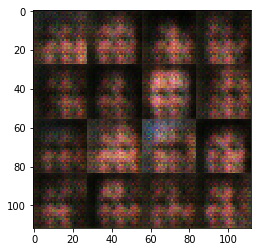

Epoch 1/1 Step 141/791: Discriminator Loss: 1.0614. Generator Loss: 0.8512
Epoch 1/1 Step 146/791: Discriminator Loss: 1.0626. Generator Loss: 0.7905
Epoch 1/1 Step 151/791: Discriminator Loss: 1.0869. Generator Loss: 0.8419
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


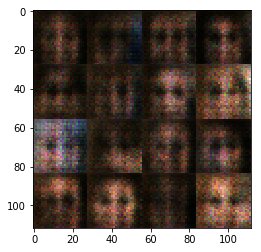

Epoch 1/1 Step 156/791: Discriminator Loss: 0.9783. Generator Loss: 0.7545
Epoch 1/1 Step 161/791: Discriminator Loss: 0.9422. Generator Loss: 1.1423
Epoch 1/1 Step 166/791: Discriminator Loss: 1.2931. Generator Loss: 0.7731
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


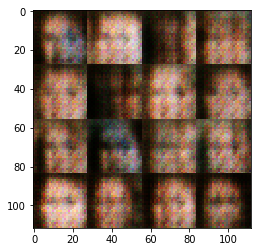

Epoch 1/1 Step 171/791: Discriminator Loss: 0.9766. Generator Loss: 0.8745
Epoch 1/1 Step 176/791: Discriminator Loss: 0.9349. Generator Loss: 0.9661
Epoch 1/1 Step 181/791: Discriminator Loss: 0.9641. Generator Loss: 0.8797
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


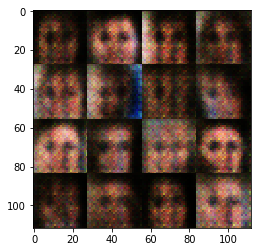

Epoch 1/1 Step 186/791: Discriminator Loss: 0.9278. Generator Loss: 1.2144
Epoch 1/1 Step 191/791: Discriminator Loss: 1.0041. Generator Loss: 0.9254
Epoch 1/1 Step 196/791: Discriminator Loss: 0.7829. Generator Loss: 1.3019
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


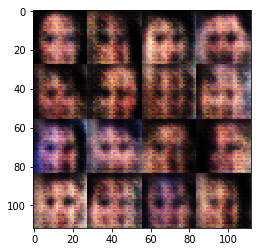

Epoch 1/1 Step 201/791: Discriminator Loss: 1.4409. Generator Loss: 0.8287
Epoch 1/1 Step 206/791: Discriminator Loss: 0.7370. Generator Loss: 1.0155
Epoch 1/1 Step 211/791: Discriminator Loss: 0.7306. Generator Loss: 1.0909
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


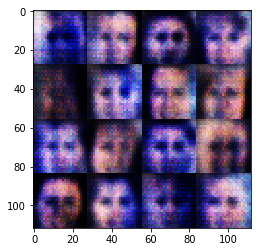

Epoch 1/1 Step 216/791: Discriminator Loss: 0.7009. Generator Loss: 1.1866
Epoch 1/1 Step 221/791: Discriminator Loss: 1.0162. Generator Loss: 0.9568
Epoch 1/1 Step 226/791: Discriminator Loss: 1.1580. Generator Loss: 1.1042
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


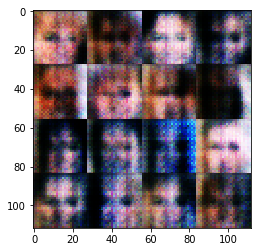

Epoch 1/1 Step 231/791: Discriminator Loss: 1.2111. Generator Loss: 0.8853
Epoch 1/1 Step 236/791: Discriminator Loss: 1.0067. Generator Loss: 0.9282
Epoch 1/1 Step 241/791: Discriminator Loss: 1.0332. Generator Loss: 0.7639
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


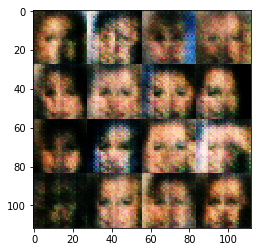

Epoch 1/1 Step 246/791: Discriminator Loss: 0.7028. Generator Loss: 1.1861
Epoch 1/1 Step 251/791: Discriminator Loss: 1.2050. Generator Loss: 0.7493
Epoch 1/1 Step 256/791: Discriminator Loss: 1.5456. Generator Loss: 0.7345
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


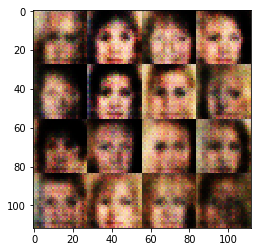

Epoch 1/1 Step 261/791: Discriminator Loss: 1.0671. Generator Loss: 0.7983
Epoch 1/1 Step 266/791: Discriminator Loss: 0.9788. Generator Loss: 0.9370
Epoch 1/1 Step 271/791: Discriminator Loss: 1.0471. Generator Loss: 0.8463
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


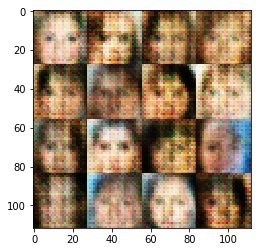

Epoch 1/1 Step 276/791: Discriminator Loss: 1.0058. Generator Loss: 0.7805
Epoch 1/1 Step 281/791: Discriminator Loss: 0.9467. Generator Loss: 1.0132
Epoch 1/1 Step 286/791: Discriminator Loss: 0.8992. Generator Loss: 1.2126
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


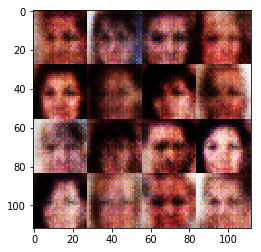

Epoch 1/1 Step 291/791: Discriminator Loss: 1.0274. Generator Loss: 0.9433
Epoch 1/1 Step 296/791: Discriminator Loss: 1.0550. Generator Loss: 0.9083
Epoch 1/1 Step 301/791: Discriminator Loss: 0.8962. Generator Loss: 0.9271
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


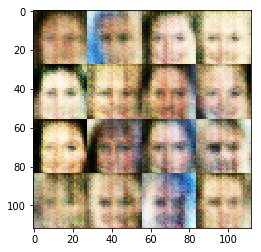

Epoch 1/1 Step 306/791: Discriminator Loss: 1.2029. Generator Loss: 0.7711
Epoch 1/1 Step 311/791: Discriminator Loss: 1.0086. Generator Loss: 0.9032
Epoch 1/1 Step 316/791: Discriminator Loss: 1.0712. Generator Loss: 0.8292
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


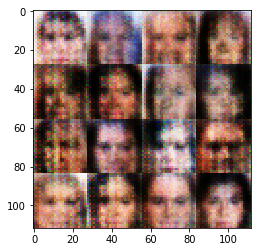

Epoch 1/1 Step 321/791: Discriminator Loss: 1.1315. Generator Loss: 0.5759
Epoch 1/1 Step 326/791: Discriminator Loss: 0.7429. Generator Loss: 1.0477
Epoch 1/1 Step 331/791: Discriminator Loss: 0.9632. Generator Loss: 1.0662
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


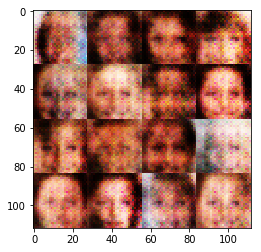

Epoch 1/1 Step 336/791: Discriminator Loss: 0.7740. Generator Loss: 1.2005
Epoch 1/1 Step 341/791: Discriminator Loss: 1.1879. Generator Loss: 0.8639
Epoch 1/1 Step 346/791: Discriminator Loss: 1.0260. Generator Loss: 0.7759
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


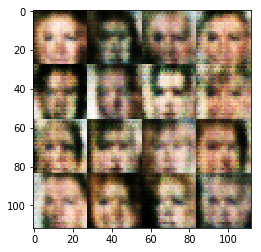

Epoch 1/1 Step 351/791: Discriminator Loss: 0.8130. Generator Loss: 1.1434
Epoch 1/1 Step 356/791: Discriminator Loss: 0.9005. Generator Loss: 0.9679
Epoch 1/1 Step 361/791: Discriminator Loss: 0.8869. Generator Loss: 0.9778
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


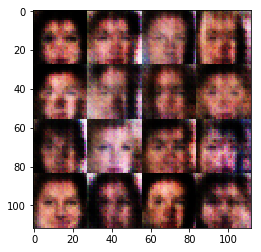

Epoch 1/1 Step 366/791: Discriminator Loss: 0.9362. Generator Loss: 0.8924
Epoch 1/1 Step 371/791: Discriminator Loss: 0.8302. Generator Loss: 1.1978
Epoch 1/1 Step 376/791: Discriminator Loss: 1.0214. Generator Loss: 0.8848
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


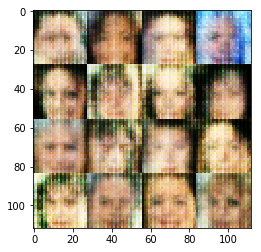

Epoch 1/1 Step 381/791: Discriminator Loss: 0.9761. Generator Loss: 0.9755
Epoch 1/1 Step 386/791: Discriminator Loss: 0.9190. Generator Loss: 0.9986
Epoch 1/1 Step 391/791: Discriminator Loss: 0.7592. Generator Loss: 1.0686
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


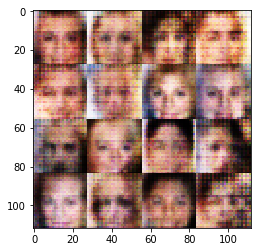

Epoch 1/1 Step 396/791: Discriminator Loss: 1.2267. Generator Loss: 0.8930
Epoch 1/1 Step 401/791: Discriminator Loss: 0.8273. Generator Loss: 1.1132
Epoch 1/1 Step 406/791: Discriminator Loss: 0.8238. Generator Loss: 1.1249
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


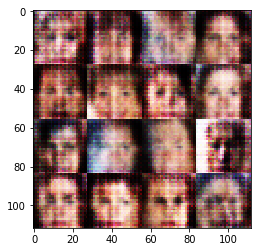

Epoch 1/1 Step 411/791: Discriminator Loss: 0.8243. Generator Loss: 0.9615
Epoch 1/1 Step 416/791: Discriminator Loss: 1.1284. Generator Loss: 1.2245
Epoch 1/1 Step 421/791: Discriminator Loss: 0.8833. Generator Loss: 0.9153
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


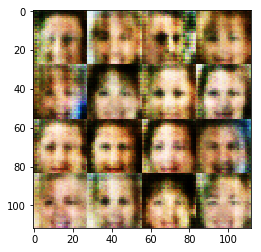

Epoch 1/1 Step 426/791: Discriminator Loss: 1.2175. Generator Loss: 1.1954
Epoch 1/1 Step 431/791: Discriminator Loss: 1.2681. Generator Loss: 0.5559
Epoch 1/1 Step 436/791: Discriminator Loss: 0.7665. Generator Loss: 1.3164
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


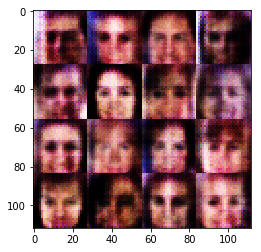

Epoch 1/1 Step 441/791: Discriminator Loss: 0.8684. Generator Loss: 1.0386
Epoch 1/1 Step 446/791: Discriminator Loss: 0.9612. Generator Loss: 1.1037
Epoch 1/1 Step 451/791: Discriminator Loss: 0.9293. Generator Loss: 0.9453
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


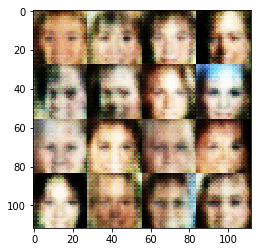

Epoch 1/1 Step 456/791: Discriminator Loss: 0.8800. Generator Loss: 1.0521
Epoch 1/1 Step 461/791: Discriminator Loss: 0.9434. Generator Loss: 0.8717
Epoch 1/1 Step 466/791: Discriminator Loss: 1.1692. Generator Loss: 0.8219
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


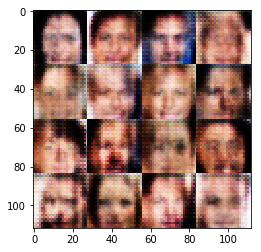

Epoch 1/1 Step 471/791: Discriminator Loss: 0.8312. Generator Loss: 1.0804
Epoch 1/1 Step 476/791: Discriminator Loss: 0.9589. Generator Loss: 0.9190
Epoch 1/1 Step 481/791: Discriminator Loss: 0.7113. Generator Loss: 1.3957
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


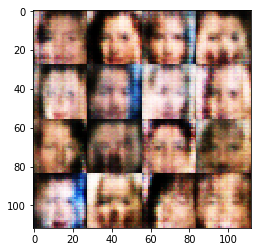

Epoch 1/1 Step 486/791: Discriminator Loss: 1.3065. Generator Loss: 1.1628
Epoch 1/1 Step 491/791: Discriminator Loss: 1.0095. Generator Loss: 1.0490
Epoch 1/1 Step 496/791: Discriminator Loss: 0.9723. Generator Loss: 0.8576
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


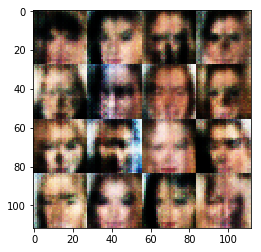

Epoch 1/1 Step 501/791: Discriminator Loss: 0.6535. Generator Loss: 1.2255
Epoch 1/1 Step 506/791: Discriminator Loss: 0.8444. Generator Loss: 1.5104
Epoch 1/1 Step 511/791: Discriminator Loss: 0.9864. Generator Loss: 1.1885
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


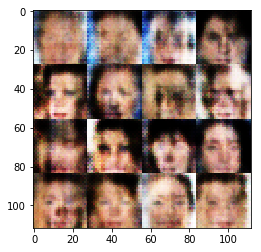

Epoch 1/1 Step 516/791: Discriminator Loss: 0.8470. Generator Loss: 1.2788
Epoch 1/1 Step 521/791: Discriminator Loss: 0.7102. Generator Loss: 1.0642
Epoch 1/1 Step 526/791: Discriminator Loss: 0.7796. Generator Loss: 1.7256
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


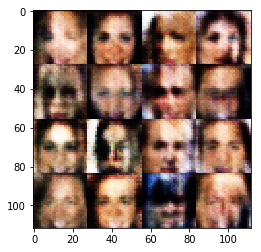

Epoch 1/1 Step 531/791: Discriminator Loss: 1.0200. Generator Loss: 1.6195
Epoch 1/1 Step 536/791: Discriminator Loss: 0.7869. Generator Loss: 0.9099
Epoch 1/1 Step 541/791: Discriminator Loss: 0.9193. Generator Loss: 1.2160
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


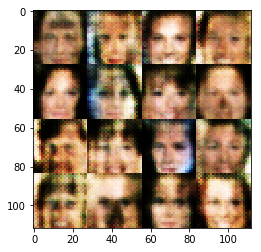

Epoch 1/1 Step 546/791: Discriminator Loss: 0.5646. Generator Loss: 1.4098
Epoch 1/1 Step 551/791: Discriminator Loss: 0.5155. Generator Loss: 1.4603
Epoch 1/1 Step 556/791: Discriminator Loss: 0.5296. Generator Loss: 2.0547
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


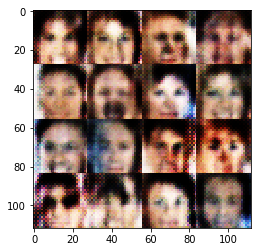

Epoch 1/1 Step 561/791: Discriminator Loss: 0.5696. Generator Loss: 1.7228
Epoch 1/1 Step 566/791: Discriminator Loss: 1.0422. Generator Loss: 1.4434
Epoch 1/1 Step 571/791: Discriminator Loss: 0.5752. Generator Loss: 1.2781
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


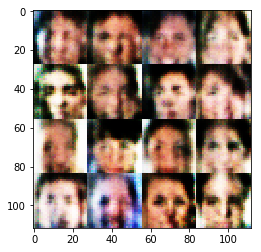

Epoch 1/1 Step 576/791: Discriminator Loss: 0.4347. Generator Loss: 1.9529
Epoch 1/1 Step 581/791: Discriminator Loss: 0.5096. Generator Loss: 1.5042
Epoch 1/1 Step 586/791: Discriminator Loss: 0.5501. Generator Loss: 1.3551
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


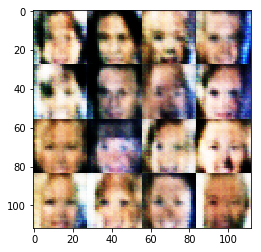

Epoch 1/1 Step 591/791: Discriminator Loss: 0.4355. Generator Loss: 1.4127
Epoch 1/1 Step 596/791: Discriminator Loss: 0.7827. Generator Loss: 2.0658
Epoch 1/1 Step 601/791: Discriminator Loss: 1.2254. Generator Loss: 0.9266
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


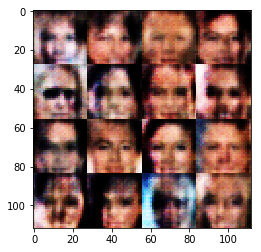

Epoch 1/1 Step 606/791: Discriminator Loss: 1.2732. Generator Loss: 0.9725
Epoch 1/1 Step 611/791: Discriminator Loss: 0.9261. Generator Loss: 1.3943
Epoch 1/1 Step 616/791: Discriminator Loss: 0.8701. Generator Loss: 0.9030
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


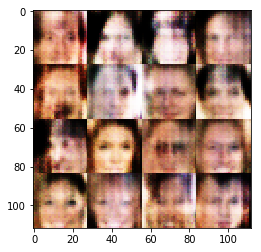

Epoch 1/1 Step 621/791: Discriminator Loss: 0.8210. Generator Loss: 1.1721
Epoch 1/1 Step 626/791: Discriminator Loss: 0.7958. Generator Loss: 1.0140
Epoch 1/1 Step 631/791: Discriminator Loss: 0.6834. Generator Loss: 1.6473
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


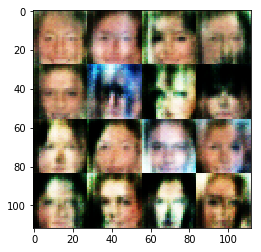

Epoch 1/1 Step 636/791: Discriminator Loss: 0.6838. Generator Loss: 1.3342
Epoch 1/1 Step 641/791: Discriminator Loss: 0.6311. Generator Loss: 1.8847
Epoch 1/1 Step 646/791: Discriminator Loss: 0.4844. Generator Loss: 1.4899
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


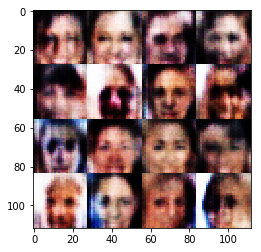

Epoch 1/1 Step 651/791: Discriminator Loss: 0.6695. Generator Loss: 1.1096
Epoch 1/1 Step 656/791: Discriminator Loss: 0.6218. Generator Loss: 2.1317
Epoch 1/1 Step 661/791: Discriminator Loss: 1.0084. Generator Loss: 1.5276
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


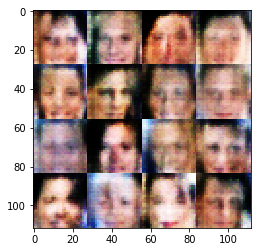

Epoch 1/1 Step 666/791: Discriminator Loss: 0.8076. Generator Loss: 1.0952
Epoch 1/1 Step 671/791: Discriminator Loss: 0.5289. Generator Loss: 1.7034
Epoch 1/1 Step 676/791: Discriminator Loss: 0.5565. Generator Loss: 1.3120
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


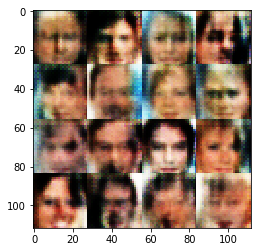

Epoch 1/1 Step 681/791: Discriminator Loss: 0.6957. Generator Loss: 1.9516
Epoch 1/1 Step 686/791: Discriminator Loss: 0.5066. Generator Loss: 1.5033
Epoch 1/1 Step 691/791: Discriminator Loss: 0.4270. Generator Loss: 1.7745
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


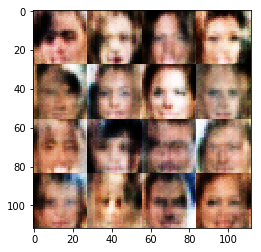

Epoch 1/1 Step 696/791: Discriminator Loss: 0.6196. Generator Loss: 1.5046
Epoch 1/1 Step 701/791: Discriminator Loss: 0.6856. Generator Loss: 1.0652
Epoch 1/1 Step 706/791: Discriminator Loss: 0.4303. Generator Loss: 1.6904
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


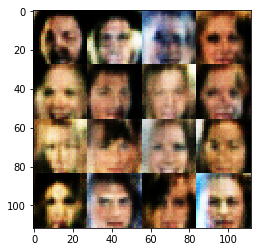

Epoch 1/1 Step 711/791: Discriminator Loss: 0.6979. Generator Loss: 1.2273
Epoch 1/1 Step 716/791: Discriminator Loss: 0.6676. Generator Loss: 2.0263
Epoch 1/1 Step 721/791: Discriminator Loss: 0.5250. Generator Loss: 1.4256
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


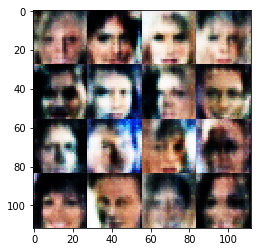

Epoch 1/1 Step 726/791: Discriminator Loss: 0.5329. Generator Loss: 1.3052
Epoch 1/1 Step 731/791: Discriminator Loss: 0.4590. Generator Loss: 1.8436
Epoch 1/1 Step 736/791: Discriminator Loss: 1.2722. Generator Loss: 1.9986
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


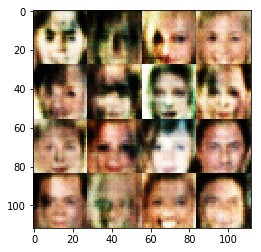

Epoch 1/1 Step 741/791: Discriminator Loss: 1.0278. Generator Loss: 2.0483
Epoch 1/1 Step 746/791: Discriminator Loss: 1.5861. Generator Loss: 1.3161
Epoch 1/1 Step 751/791: Discriminator Loss: 1.5326. Generator Loss: 0.7894
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


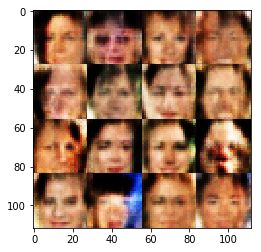

Epoch 1/1 Step 756/791: Discriminator Loss: 0.8598. Generator Loss: 0.9749
Epoch 1/1 Step 761/791: Discriminator Loss: 1.0552. Generator Loss: 0.9126
Epoch 1/1 Step 766/791: Discriminator Loss: 0.7821. Generator Loss: 1.0349
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


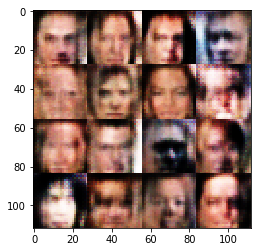

Epoch 1/1 Step 771/791: Discriminator Loss: 0.7925. Generator Loss: 0.9706
Epoch 1/1 Step 776/791: Discriminator Loss: 0.6529. Generator Loss: 1.0616
Epoch 1/1 Step 781/791: Discriminator Loss: 1.0898. Generator Loss: 1.2422
generator out (?, 28, 28, 3)
after scaling (?, 28, 28, 3)
gen images 16 (16, 100) -> (16, 28, 28, 3)


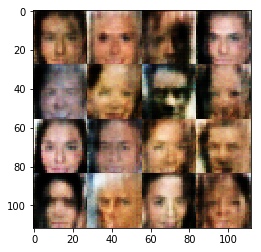

Epoch 1/1 Step 786/791: Discriminator Loss: 0.9349. Generator Loss: 1.0949
Epoch 1/1 Step 791/791: Discriminator Loss: 0.7305. Generator Loss: 1.1678


In [20]:
batch_size = 256
z_dim = 100
learning_rate = 0.00025
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.